<a href="https://colab.research.google.com/github/puneethkumarvydya/Capstone-Project/blob/Ganesh's-Branch/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection 

Project content
1. EDA
1.1, check and display sample Data
1.2, Load the dataset and processing images and labels.
1.3, Print the different sizes of the datasets. To see the size in each.
1.3.1, Display sample dataset in numpy Array format.
2. ,Modeling
2.1, Load VGG16, Mobilenet and resnet50 trained weights and replace the output layers
2.2, comparing Imported Model and Our New Modified Model
2.2.1, Locking our Trainable weights except for the last two layers
2.3, Selcting Loss function and Compiling Model
2.4, Training the Model
2.5, Plotting the Learning Curve as per NO of epoch
2.6, Model Testing
2.7, Model Performance (Confusion Matrix)
2.8, Model ROC curve
2.9, Saving the Model
2.10, Reloading and checking the Model
2.11, Sample predictions for a given image using Google Colab
2.12, Deploying the Model in web App using Flask frame work

In [ ]:
pip install pydicom

###Import Packages

In [ ]:
import pydicom as dicom # for reading dcom files
import os
from os import listdir
from os.path import isfile, join
# print(os.listdir("../input"))

# Basic library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob

# Data preprocessing
import cv2 # Open cv

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Machine learning library
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Validation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.patches as patches

from matplotlib.patches import Rectangle

In [ ]:
print(np.__version__)

1.18.5


In [ ]:
 #Importing the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Changing the directory

os.chdir('/content/drive/My Drive/AIML/Capstone 1')
#path = ('.')
os.listdir()

['rsna-pneumonia-detection-challenge.zip',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv']

### Load & Read the data

# NOTE:   This is we used for files to be Unzipped once, then no need to do unzip command again and again. It will checked automatically is any file zipped or not, if zipped then upzipped.

In [ ]:
from pathlib import Path
my_file = Path("GCP Credits Request Link - RSNA.txt")
if my_file.is_file():
    print("File is unzipped")
else:
  print("File needs to be unzipped")
  from zipfile import ZipFile
  with ZipFile("rsna-pneumonia-detection-challenge.zip",'r') as z:
    z.extractall()
    os.listdir()  

File is unzipped


## Data Overview
### Stage 2 Images - `stage_2_train_images.zip` and `stage_2_test_images.zip`
- images for the current stage. Filenames are also patient names.

### Stage 2 Labels - `stage_2_train_labels.csv` and Stage 2 Sample Submission `stage_2_sample_submission.csv`
- Which provides the IDs for the test set, as well as a sample of what your submission should look like

### Stage 2 Detailed Info - `stage_2_detailed_class_info.csv`
- contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models.

# Load the tabular data for detailed_class_info 

In [ ]:
classinfo = pd.read_csv("stage_2_detailed_class_info.csv")

In [ ]:
classinfo.sample(5)

,patientId,class
10797,71de0642-614b-4043-85ba-79a325c0a4a9,No Lung Opacity / Not Normal
28768,fe6a671e-ab77-4a45-af7e-1fb715efd15f,No Lung Opacity / Not Normal
25030,e07e0635-2b05-435a-b6db-15dfd081f207,Normal
20656,bc88fe07-10a9-4032-9a0b-21f57f10d555,Lung Opacity
5356,463c04a5-94b8-4969-a725-a58c2b6211c1,Lung Opacity


### Data Exploration

####  EDA on the classinfo file. 


#We start by exploring the classinfo data, we extract the information from this and visualize the various features of this, no. of target classes etc

---



In [ ]:
classinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   Class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
classinfo.rename(columns = {'class':'Class'}, inplace = True)

let's check the number of target classes and its names.

In [ ]:
print("Number of classes in the dataset :: %i" %  len(classinfo["Class"].unique()))
print("Classes' names are :: %s" % classinfo["Class"].unique())


Number of classes in the dataset :: 3
Classes' names are :: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


In [ ]:
classinfo.nunique()

patientId    26684
Class            3
dtype: int64

In [ ]:
classinfo.Class.value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: Class, dtype: int64

###Missing data

Let's check missing information in the dataset.

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    print("total",total)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(classinfo)

total Class        0
patientId    0
dtype: int64


,Class,patientId
Total,0.0,0.0
Percent,0.0,0.0


In [ ]:
missing_data(classinfo)

total Class        0
patientId    0
dtype: int64


,Class,patientId
Total,0.0,0.0
Percent,0.0,0.0


The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity).

Let's check the class distribution from class detailed info.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


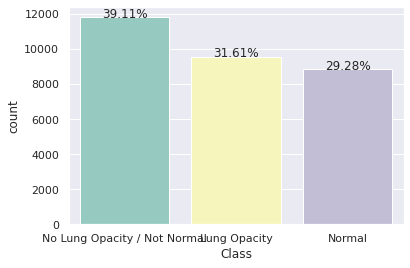

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(classinfo))
sns.countplot(classinfo['Class'],order = classinfo['Class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

Let's look into more details to the classes

In [ ]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(classinfo, 'Class')

Feature: Class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


#Insights:

*No* Lung Opacity / Not Normal and Normal have together the same percent (69.077%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with value for Target = 1 is therefore 30.92%.

### Distribution of classinfo

In [ ]:
classinfo.groupby(["Class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

Class,Lung Opacity,No Lung Opacity / Not Normal,Normal
patientId,9555,11821,8851


#Insights:-
9555 patients are in class of 'Lung Opacity', 11821 are in 'No Lung Opacity / Not Normal' and 8851 are in Normal category.

# Let's do EDA on train labels file

In [ ]:
train_label = pd.read_csv("stage_2_train_labels.csv")

In [ ]:
train_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
train_label.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


#We shall use missing_data class to check missing information in the dataset.

In [ ]:
missing_data(train_label)

total height       20672
width        20672
y            20672
x            20672
Target           0
patientId        0
dtype: int64


,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


# Merging of train and class detail info data

Let's merge the two datasets(train label & classinfo), using Patient ID as the merge criteria.

In [ ]:
train_class_df = train_label.merge(classinfo, left_on='patientId', right_on='patientId', how='inner')
train_class_df.head() 

,patientId,x,y,width,height,Target,Class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


#Summary on the values, types and null values.





In [ ]:
train_class_df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
Class            0
dtype: int64

#Inference:-
Bounding box parameters x, y , width and height are having Null/NaN values

### Let's check for duplicates

Now let's store all the destinct IDs into a dataframe for future usage.

In [ ]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())  

Unique patientId in  train_class_df:  26684


#Inference:
Number of unique patinet ID is same as number of dicom image in the training set. Hence we can say that there are no duplicates in the data. 

In [ ]:
# Distribution of classes in merged data

train_class_df.groupby(["Class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

Class,Lung Opacity,No Lung Opacity / Not Normal,Normal
patientId,16957,11821,8851
x,16957,0,0
y,16957,0,0
width,16957,0,0
height,16957,0,0
Target,16957,11821,8851


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


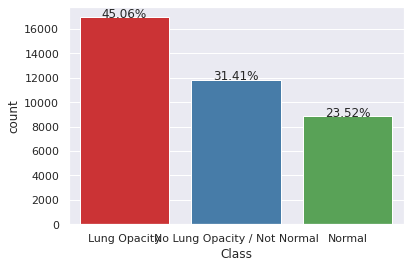

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(train_class_df))
sns.countplot(train_class_df['Class'],order = train_class_df['Class'].value_counts().index, palette='Set1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()



```
# This is formatted as code
```

# Inference:
The classes "Lung Opacity", "No Lung Opacity / Not Normal" and "Normal" are in the proportions of 45.06%, 31.41% and 23.52% respectively

### Distribution of Labels (Positive and Negative)"

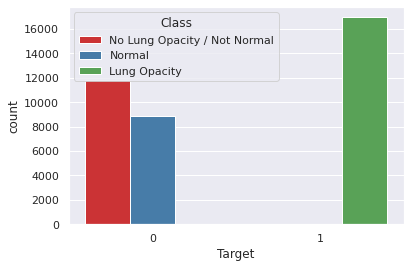

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(x = "Target", data= train_class_df, hue="Class", palette='Set1')

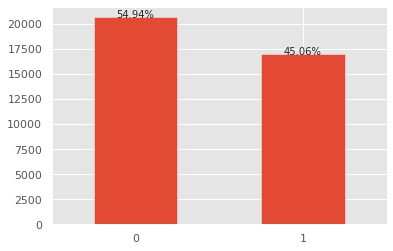

In [ ]:
plt.style.use('ggplot')
f, ax = plt.subplots(1,1, figsize=(6,4))
totale = float(len(train_class_df))
pd.value_counts(train_class_df["Target"]).plot(kind='bar', position=0.5, rot=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

# Inference
All chest examinations with Target 1 (pathology detected) is associated with class: Lung Opacity.

The chest examinations with Target 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

### Let's check the Number of positive targets

In [ ]:

print(round((9555 / (9555 + 20672)) * 100, 2), '% of the patients are positive')

31.61 % of the patients are positive


In [ ]:
train_class_df.groupby(["Target"]).count()

,patientId,x,y,width,height,Class
Target,,,,,,
0,20672,0,0,0,0,20672
1,16957,16957,16957,16957,16957,16957


### Insight:

Patients with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal don't have bounding box coordinates (x, y, w, h) parameters. 31.61% of the patients belongs to Lung Opacity class.


### Detected Lung Opacity window


For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.




/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

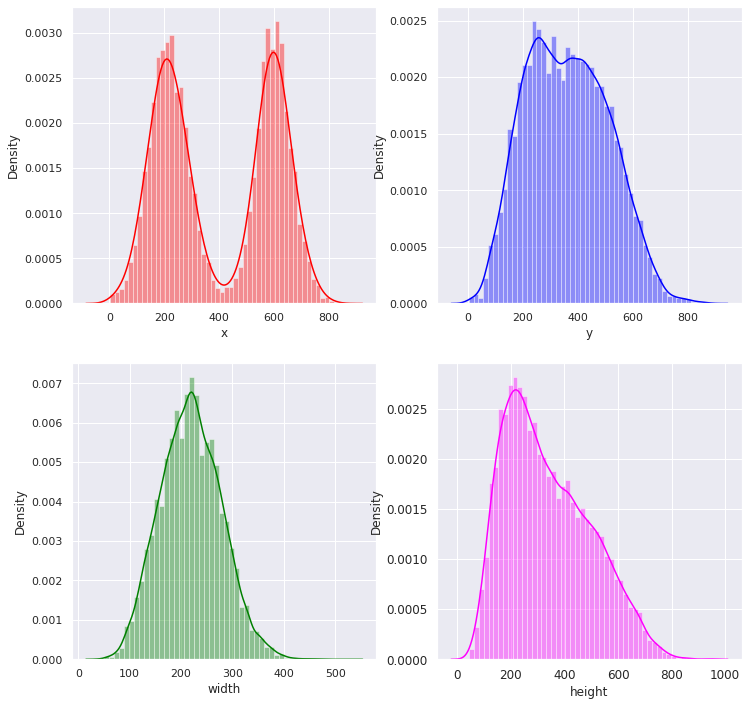

In [ ]:
target1 = train_class_df[train_class_df['Target']==1]
#sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We will show a sample of center points superposed with the corresponding sample of the rectangles.

### Lung Opacity Representation (2000 samples)

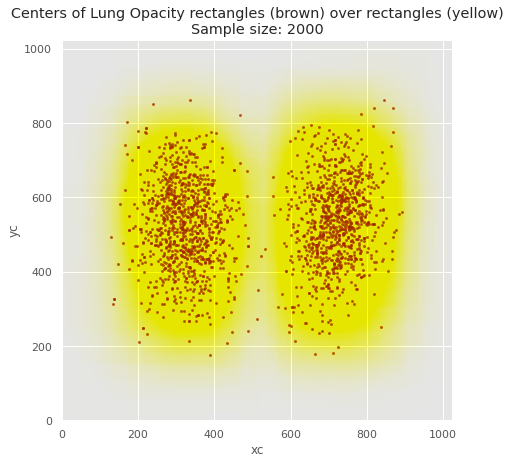

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [ ]:
tmp = train_class_df.groupby(['patientId','Target', 'Class'])['patientId'].count()
tmp

patientId                             Target  Class                       
0004cfab-14fd-4e49-80ba-63a80b6bddd6  0       No Lung Opacity / Not Normal    1
000924cf-0f8d-42bd-9158-1af53881a557  0       Normal                          1
000db696-cf54-4385-b10b-6b16fbb3f985  1       Lung Opacity                    4
000fe35a-2649-43d4-b027-e67796d412e0  1       Lung Opacity                    4
001031d9-f904-4a23-b3e5-2c088acd19c6  1       Lung Opacity                    4
                                                                             ..
fffb2395-8edd-4954-8a89-ffe2fd329be3  1       Lung Opacity                    4
fffba05a-1635-4545-9bbd-57ad4cfe8d27  0       Normal                          1
fffc95b5-605b-4226-80ab-62caec682b22  0       No Lung Opacity / Not Normal    1
fffcff11-d018-4414-971a-a7cefa327795  0       No Lung Opacity / Not Normal    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136  0       No Lung Opacity / Not Normal    1
Name: patientId, Length: 26684, dtype: int64

In [ ]:
tmp.values

array([1, 1, 4, ..., 1, 1, 1])

In [ ]:
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
df.head()
tmp = df.groupby(['Exams','Target','Class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,4,1,Lung Opacity,3266
4,9,1,Lung Opacity,119
5,16,1,Lung Opacity,13


Duplicate patientIDs are different in the training label. This might be because of same patientID might have multiple opacity. 

In [ ]:
df2.Exams.value_counts()

1     3
4     1
9     1
16    1
Name: Exams, dtype: int64

#Let's see what entries are duplicated. We want to check how are these distributed accross classes and Target value.

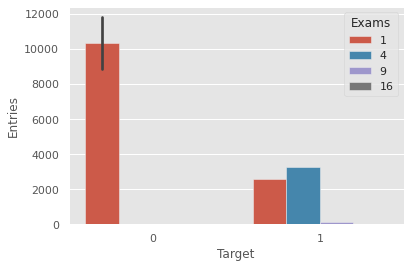

In [ ]:
sns.barplot(x = 'Target', y='Entries', hue='Exams',data=df2)

### Exploring Images

We will explore images from the dataset based on different age groups to see if there is a significant difference in the images to decide if we need further processing.




# Total Training Images

In [ ]:
import os
count = 0
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Training images:")
print(count)

Total Training images:
26170


# Total Test Images

In [ ]:
import os
count = 0
d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Testing images:")
print(count)

Total Testing images:
3000


# Lets Check the Shape of a Image

In [ ]:
image_path = 'stage_2_train_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm'
ds = dicom.dcmread(image_path)

print(ds.pixel_array.shape)

(1024, 1024)


# Lets move the shape of all images to a CSV file and look for any abberations

---



In [ ]:
import pickle
import os
import pydicom as dicom

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        imgshape = ds.pixel_array.shape
        data = data + path + ',' + str(imgshape) + ',' + '\n'
        with open('images_train_shape.csv', 'wb') as fp:
            pickle.dump(data, fp)

# Insights:-
The CSV file shows us the shape of all images is the same - 1024 x 1024

Lets now do this for the test images

In [ ]:
import pickle

d = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        imgshape = ds.pixel_array.shape
        data = data + path + ',' + str(imgshape) + ',' + '\n'
        with open('images_test_shape.csv', 'wb') as fp:
            pickle.dump(data, fp)

# Inference:-
The shape for all test images are the same - 1024 x 1024

Now lets look at the sizes of the images

In [ ]:
# 35

min_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
max_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46234
370560


#Inference:- 
It shows the size of the images vary from 46kB to 370kB. This is a varied set and will help in getting a good **training**



Lets now plot the smallest size and the largest size image

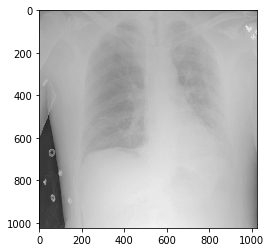

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt

image_path = 'stage_2_train_images/' + min_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

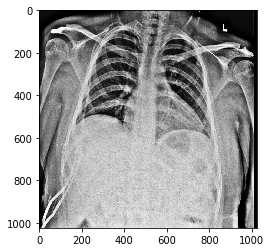

In [ ]:
image_path = 'stage_2_train_images/' + max_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

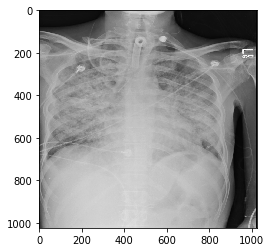

In [ ]:
image_path = 'stage_2_train_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array,cmap='gray')

#Lets now find the the image sizes for the test folder

In [ ]:
min_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
max_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46242
189830


# Insights 
It varies from 46kB to 189kB

#Lets now randomly plot an image from the train folder

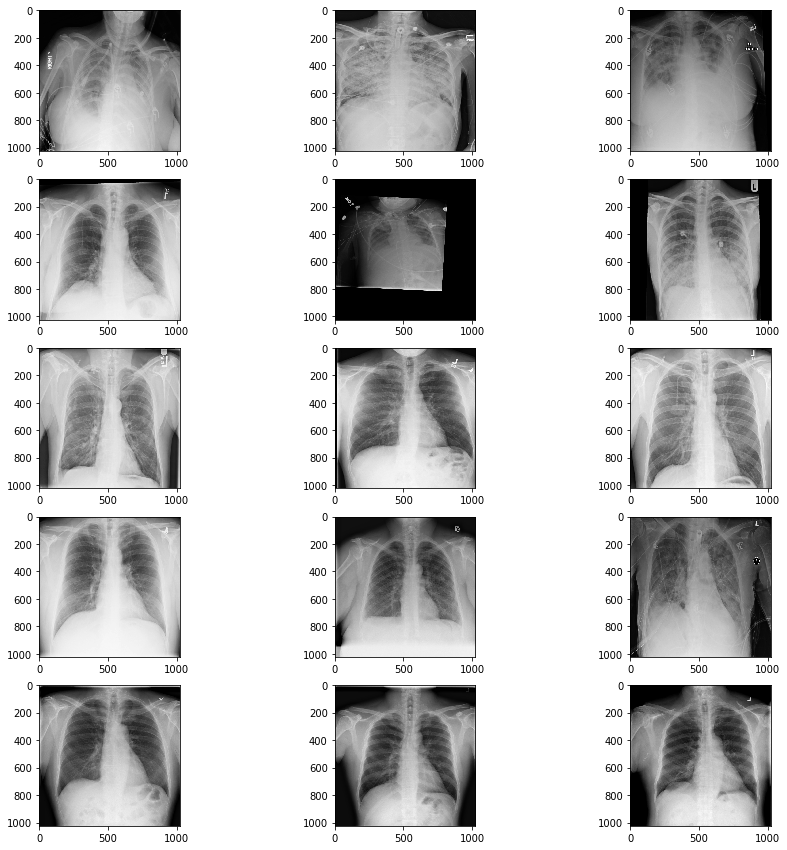

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt
import os

count = 1
plt.figure(figsize= (15,15))
d = "images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        plt.subplot(5,3,count)
        plt.imshow(ds.pixel_array,cmap='gray')
        count += 1

#Lets now plot the couple of images with the bounding box

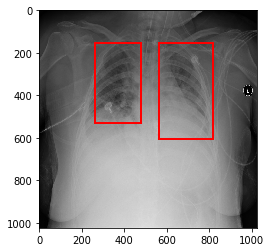

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom as dicom

fig,ax = plt.subplots(1)
image_path = 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
ds = dicom.dcmread(image_path)
ax.imshow(ds.pixel_array, cmap='gray')
rect1 = patches.Rectangle((264, 152), 213, 379, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((562, 152), 256, 453, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

plt.show()

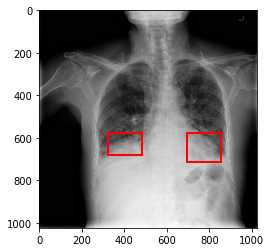

In [ ]:
fig,ax = plt.subplots(1)
image_path = 'stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm'
ds = dicom.dcmread(image_path)
ax.imshow(ds.pixel_array, cmap='gray')
rect1 = patches.Rectangle((323, 577), 160, 104, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((695, 575), 162, 137, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

plt.show()

#Lets now print the metadata of one of the dicom images

In [ ]:
image_path = 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
ds = dicom.dcmread(image_path, force = True)

ds
#plt.imshow(ds.pixel_array,cmap='gray')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

# Inference:

The metadata shows us that we can use some of the details present like Age, Sex, Body Part Examined, View Position, Modality, Rows and Columns, pixel spacing etc as features. This might be helpful in improving the model performance. More on this later.

Lets now move the metadata to an CSV file. We will need this data later. Lets do this for both train and test folder.



In [ ]:
import pickle

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_train.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
d = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_test.csv', 'wb') as fp:
            pickle.dump(data, fp)

# What does the submission look like?

### Stage 2 Labels - `stage_2_train_labels.csv` and Stage 2 Sample Submission `stage_2_sample_submission.csv`
- Which provides the IDs for the test set, as well as a sample of what your submission should look like

In [ ]:
#pd.read_csv('/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_sample_submission.csv').head()
sample_submission= pd.read_csv("stage_2_sample_submission.csv")

In [ ]:
sample_submission.head(5)

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [ ]:
train_label = pd.read_csv("stage_2_train_labels.csv")

In [ ]:
train_label.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
train_label.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
train_label.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
train_label['Target'].unique()

array([0, 1])

In [ ]:
train_label.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [ ]:
#train_label = pd.read_csv("stage_2_train_labels.csv")
train_label.shape

(30227, 6)

In [ ]:
DIR_train='./stage_2_train_images'
onlyfiles = next(os.walk(DIR_train))[2] #dir is your directory path as string
print ("Total training images:",len(onlyfiles))

Total training images: 26684


In [ ]:
DIR_test='./stage_2_test_images'
onlyfiles = next(os.walk(DIR_test))[2] #dir is your directory path as string
print ("Total test images:",len(onlyfiles))

Total test images: 3000


# EDA of Detailed Class Info

In [ ]:
dat1 = ds[16,32].value
dat2 = ds[16,64].value
dat3 = ds[16,4112].value
dat4 = ds[24,21].value

In [ ]:
import pickle

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_train.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
d = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_test.csv', 'wb') as fp:
            pickle.dump(data, fp)

## Size of the impacted area
We can make a new feature called "area" to the train labels data to see what the distribution of areas label look like.

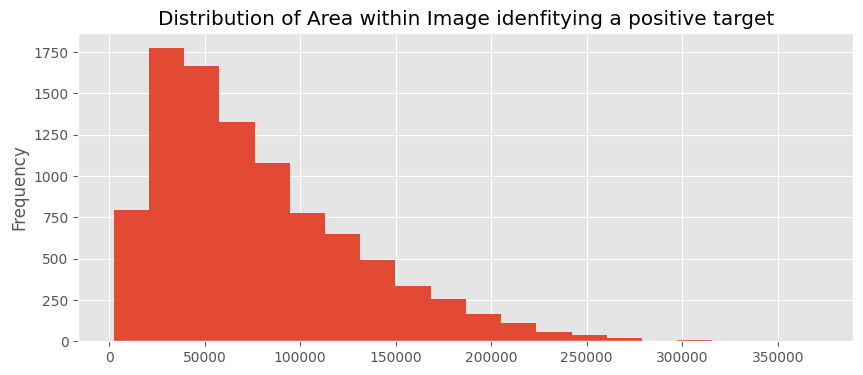

In [ ]:
plt.style.use('ggplot')
train_label['area'] = train_label['width'] * train_label['height']
plot = train_label['area'].plot(kind='hist',
                          figsize=(10,4),
                          bins=20,
                          title='Distribution of Area within Image idenfitying a positive target')

# Plotting Boxes around Images


In [ ]:
classinfo['Class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: Class, dtype: int64

In [ ]:
#classinfo.rename(columns = {'class':'Class'}, inplace = True)

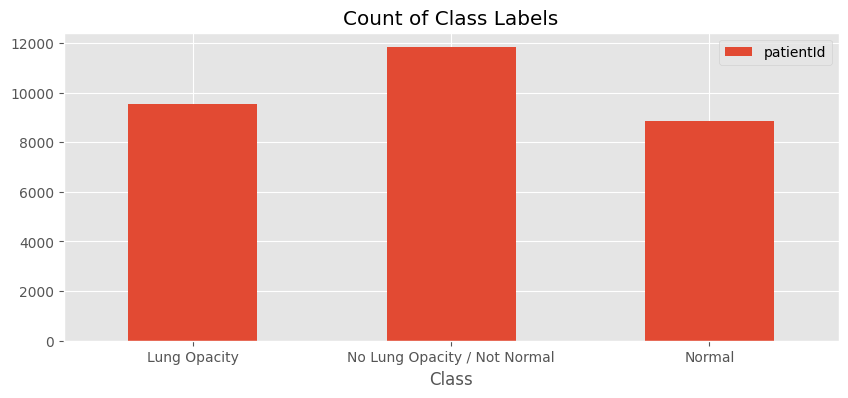

In [ ]:
plt.style.use('ggplot')
plot = classinfo.groupby('Class').count().plot(kind='bar',
                                                  rot=0,
                                                  title='Count of Class Labels',
                                                  figsize=(10,4))

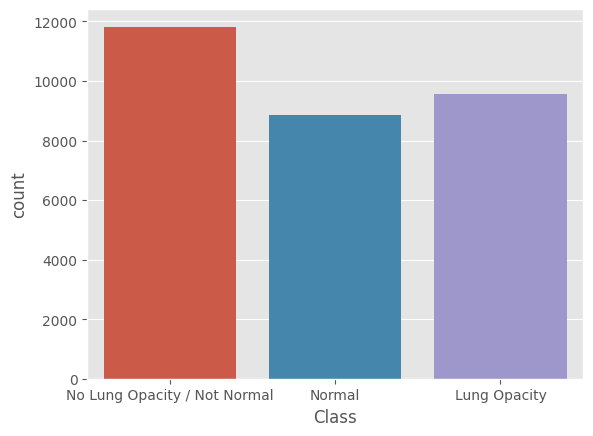

In [ ]:
import seaborn as sb

sb.countplot(x='Class',data=classinfo)

# END OF THE EDA PART